# Evolving a Lunar Lander with differentiable Genetic Programming

## Installation
To install the required libraries run the command:

In [1]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


## Imports
Imports from the standard genepro-multi library are done here. Any adjustments (e.g. different operators) should be made in the notebook. For example:

```
class SmoothOperator(Node):
  def __init__(self):
    super(SmoothOperator,self).__init__()
    self.arity = 1
    self.symb = "SmoothOperator"

  def _get_args_repr(self, args):
    return self._get_typical_repr(args,'before')

  def get_output(self, X):
    c_outs = self._get_child_outputs(X)
    return np.smoothOperation(c_outs[0])

  def get_output_pt(self, X):
    c_outs = self._get_child_outputs_pt(X)
    return torch.smoothOperation(c_outs[0])
```

In [67]:
import gymnasium as gym

from genepro.node_impl import *
from genepro.evo import Evolution
from genepro.node_impl import Constant

import torch
import torch.optim as optim

import random
import os
import copy
from collections import namedtuple, deque

import matplotlib.pyplot as plt
from matplotlib import animation

## Reinforcement Learning Setup
Here we first setup the Gymnasium environment. Please see https://gymnasium.farama.org/environments/box2d/lunar_lander/ for more information on the environment. 

Then a memory buffer is made. This is a buffer in which state transitions are stored. When the buffer reaches its maximum capacity old transitions are replaced by new ones.

A frame buffer is initialised used to later store animation frames of the environment.

In [68]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")

In [69]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    def __iadd__(self, other):
      self.memory += other.memory
      return self 

    def __add__(self, other):
      self.memory = self.memory + other.memory 
      return self

In [70]:
frames = []

## Fitness Function

Here you get to be creative. The default setup evaluates 5 episodes of 300 frames. Think of what action to pick and what fitness function to use. The Multi-tree takes an input of $n \times d$ where $n$ is a batch of size 1.

### Baseline

In [ ]:
def fitness_function_pt(multitree, num_episodes=5, episode_duration=300, render=False, ignore_done=False):
  memory = ReplayMemory(10000)
  rewards = []

  for _ in range(num_episodes):
    # get initial state of the environment
    observation = env.reset()
    observation = observation[0]
    
    for _ in range(episode_duration):
      if render:
        frames.append(env.render())

      input_sample = torch.from_numpy(observation.reshape((1,-1))).float()
      
      # what goes here? TODO
      action = torch.argmax(multitree.get_output_pt(input_sample))
      observation, reward, terminated, truncated, info = env.step(action.item())
      rewards.append(reward)
      output_sample = torch.from_numpy(observation.reshape((1,-1))).float()
      memory.push(input_sample, torch.tensor([[action.item()]]), output_sample, torch.tensor([reward]))
      if (terminated or truncated) and not ignore_done:
        break

  fitness = np.sum(rewards)
  
  return fitness, memory

### Fitness Function with Success Bonus and Crash Penalty (MKhedr)

In [90]:
def fitness_with_success_shaping(multitree, num_episodes=5, episode_duration=300, render=False, ignore_done=False):
    memory = ReplayMemory(10000)
    rewards = []

    for _ in range(num_episodes):
        observation = env.reset()[0]

        ep_reward = 0
        for _ in range(episode_duration):
            if render:
                frames.append(env.render())

            input_sample = torch.from_numpy(observation.reshape((1, -1))).float()
            action_scores = multitree.get_output_pt(input_sample)
            action = action_scores.argmax(dim=1)

            observation, reward, terminated, truncated, info = env.step(action.item())
            ep_reward += reward

            output_sample = torch.from_numpy(observation.reshape((1, -1))).float()
            memory.push(input_sample, torch.tensor([action.item()]), output_sample, torch.tensor([reward]))

            if (terminated or truncated) and not ignore_done:
                break

        # -----------------------------------------
        if ep_reward > 200:
            ep_reward += 100  # Solved
        elif terminated:
            ep_reward -= 100  # Crash
        # -----------------------------------------

        rewards.append(ep_reward)

    fitness = np.sum(rewards)
    return fitness, memory


## Evolution Setup
Here the leaf and internal nodes are defined. Think about the odds of sampling a constant in this default configurations. Also think about any operators that could be useful and add them here. 

Adjust the population size (multiple of 8 if you want to use the standard tournament selection), max generations and max tree size to taste. Be aware that each of these settings can increase the runtime.

In [91]:
num_features = env.observation_space.shape[0]
leaf_nodes = [Feature(i) for i in range(num_features)]
leaf_nodes = leaf_nodes + [Constant()] # Think about the probability of sampling a coefficient
internal_nodes = [Plus(),Minus(),Times(),Div()] #Add your own operators here

evo = Evolution(
  fitness_function_pt, internal_nodes, leaf_nodes,
  4,
  pop_size=16,
  max_gens=10,
  max_tree_size=31,
  n_jobs=8,
  verbose=True)

evo_new = Evolution(
  fitness_with_success_shaping, internal_nodes, leaf_nodes,
  4,
  pop_size=16,
  max_gens=10,
  max_tree_size=31,
  n_jobs=8,
  verbose=True)

## Evolve
Running this cell will use all the settings above as parameters

In [92]:
evo.evolve()

gen: 1,	best of gen fitness: -603.497,	best of gen size: 25
gen: 2,	best of gen fitness: -644.789,	best of gen size: 25
gen: 3,	best of gen fitness: -743.247,	best of gen size: 25
gen: 4,	best of gen fitness: -682.305,	best of gen size: 25
gen: 5,	best of gen fitness: -854.237,	best of gen size: 25
gen: 6,	best of gen fitness: -620.659,	best of gen size: 25
gen: 7,	best of gen fitness: -639.854,	best of gen size: 25
gen: 8,	best of gen fitness: -490.082,	best of gen size: 25
gen: 9,	best of gen fitness: -541.814,	best of gen size: 29
gen: 10,	best of gen fitness: -521.536,	best of gen size: 29


In [93]:
evo_new.evolve()

gen: 1,	best of gen fitness: -1129.897,	best of gen size: 23
gen: 2,	best of gen fitness: -1013.171,	best of gen size: 25
gen: 3,	best of gen fitness: -1001.230,	best of gen size: 25
gen: 4,	best of gen fitness: -823.739,	best of gen size: 25
gen: 5,	best of gen fitness: -1039.507,	best of gen size: 25
gen: 6,	best of gen fitness: -949.462,	best of gen size: 25
gen: 7,	best of gen fitness: -926.607,	best of gen size: 25
gen: 8,	best of gen fitness: -921.906,	best of gen size: 27
gen: 9,	best of gen fitness: -1041.413,	best of gen size: 25
gen: 10,	best of gen fitness: -994.602,	best of gen size: 25


# Test

## Baseline

In [96]:
def get_test_score(tree):
    rewards = []

    for i in range(10):
      # get initial state
      observation = env.reset(seed=i)
      observation = observation[0]

      for _ in range(500):    
        # build up the input sample for GP
        input_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        # get output (squeezing because it is encapsulated in an array)
        output = tree.get_output_pt(input_sample)
        action = output.argmax(dim=1) # What goes here?
        observation, reward, terminated, truncated, info = env.step(action.item())
        rewards.append(reward)


        output_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        if (terminated or truncated):
            break

    fitness = np.sum(rewards)
    
    return fitness

best = evo.best_of_gens[-1]

print(best.get_readable_repr())
print("Standard test score:", get_test_score(best))

['((((0.8840101361274719*x_3)/x_6)+((x_3*x_4)+(x_1+x_5)))/((x_7+(x_6*x_0))+((x_6-x_4)/x_3)))', '((((x_0/x_1)-x_3)-x_3)/(((((x_0/x_1)-x_3)-x_3)/(x_3-((x_4-x_6)*x_0)))-((x_4-x_6)*x_0)))', '(((x_2*x_5)/1.213302731513977)*(((x_1/x_5)/x_3)-((x_7/x_7)*(x_3/x_3))))', '((((x_1+x_0)/(x_5-x_0))+(x_6*x_4))-(((x_5+x_0)*x_3)/(-4.480809688568115-(x_1/x_0))))']
Standard test score: -1327.7725336372182


## Success Bonus and Crash Penalty 

In [97]:
def get_test_score_lookahead(tree):
    rewards = []

    for i in range(10):
        observation, _ = env.reset(seed=i)
        total_reward = 0.0

        for _ in range(500):
            input_sample = torch.from_numpy(observation.reshape((1, -1))).float()

            # Use GP tree to get action
            output = tree.get_output_pt(input_sample)
            action = output.argmax(dim=1).item()

            observation, reward, terminated, truncated, info = env.step(action)

            # Penalty terms for velocity and angle
            vel_x, vel_y = observation[2], observation[3]
            angle = observation[4]
            angular_velocity = observation[5]

            # Shape reward: penalize instability
            reward -= 0.1 * (abs(vel_x) + abs(vel_y))       # penalize fast movement
            reward -= 0.2 * abs(angle)                      # penalize tilt
            reward -= 0.05 * abs(angular_velocity)          # penalize rotation

            total_reward += reward

            if terminated or truncated:
                break

        rewards.append(total_reward)

    return np.mean(rewards)

best_new = evo_new.best_of_gens[-1]
print("Lookahead test score:", get_test_score_lookahead(best_new))

Lookahead test score: -151.74243218337264


## Make an animation
Here the best evolved individual is selected and one episode is rendered. Make sure to save your lunar landers over time to track progress and make comparisons.

In [98]:
frames = []

# gist to save gif from https://gist.github.com/botforge/64cbb71780e6208172bbf03cd9293553
def save_frames_as_gif(frames, path='./', filename='evolved_lander.gif'):
  plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
  patch = plt.imshow(frames[0])
  plt.axis('off')
  def animate(i):
      patch.set_data(frames[i])
  anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
  anim.save(path + filename, writer='imagemagick', fps=60)


MovieWriter imagemagick unavailable; using Pillow instead.


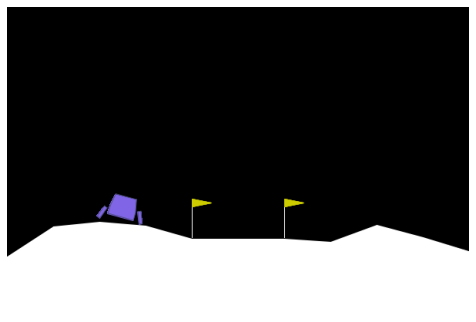

In [99]:
frames = []
fitness_function_pt(best, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
env.close()
save_frames_as_gif(frames)

MovieWriter imagemagick unavailable; using Pillow instead.


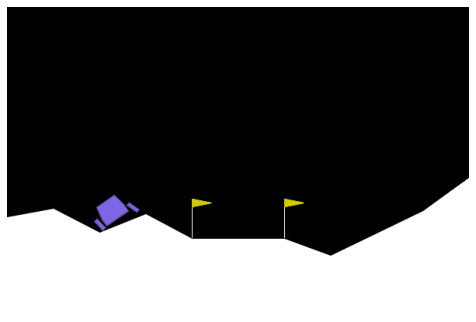

In [100]:
frames = []
fitness_with_success_shaping(best_new, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
env.close()
save_frames_as_gif(frames, filename='evolved_lander_new.gif')

## Play animation

<img src="evolved_lander.gif" width="750">

## Optimisation
The coefficients in the multi-tree aren't optimised. Here Q-learning (taken from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) is used to optimise the weights further. Incorporate coefficient optimisation in training your agent(s). Coefficient Optimisation can be expensive. Think about how often you want to optimise, when, which individuals etc.

In [103]:
batch_size = 128
GAMMA = 0.99

constants = best.get_subtrees_consts()

if len(constants)>0:
  optimizer = optim.AdamW(constants, lr=1e-3, amsgrad=True)

for _ in range(500):

  if len(constants)>0 and len(evo.memory)>batch_size:
    target_tree = copy.deepcopy(best)

    transitions = evo.memory.sample(batch_size)
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), dtype=torch.bool)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                               if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = best.get_output_pt(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(batch_size, dtype=torch.float)
    with torch.no_grad():
      next_state_values[non_final_mask] = target_tree.get_output_pt(non_final_next_states).max(1)[0].float()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
   
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(constants, 100)
    optimizer.step()


In [104]:
print(best.get_readable_repr())
print(get_test_score(best))

['((((0.6268203258514404*x_3)/x_6)+((x_3*x_4)+(x_1+x_5)))/((x_7+(x_6*x_0))+((x_6-x_4)/x_3)))', '((((x_0/x_1)-x_3)-x_3)/(((((x_0/x_1)-x_3)-x_3)/(x_3-((x_4-x_6)*x_0)))-((x_4-x_6)*x_0)))', '(((x_2*x_5)/1.6014100313186646)*(((x_1/x_5)/x_3)-((x_7/x_7)*(x_3/x_3))))', '((((x_1+x_0)/(x_5-x_0))+(x_6*x_4))-(((x_5+x_0)*x_3)/(-4.425848960876465-(x_1/x_0))))']
-1327.7725336372182


In [105]:
print(best_new.get_readable_repr())
print(get_test_score(best_new))

['((((x_0*x_2)/(x_6*x_6))+((x_0*x_3)+x_0))+((x_3-(x_5/x_4))+x_1))', '((x_6*3.263723611831665)/(((x_6*3.263723611831665)/(x_3/(x_3*(x_0-x_0))))/(x_3*(x_0-x_0))))', '((((x_2*x_4)+(x_4*x_6))*((x_3*x_5)*x_1))-(((-3.9180336018935615/x_1)/x_3)*(x_5*(x_3-x_1))))', '(((-2.2983760833740234/(x_7+x_3))/((x_7*-1.5955336261411235)-(x_7+x_4)))*((x_5+x_0)/(x_4+(x_0-x_4))))']
-1392.4777699036558


MovieWriter imagemagick unavailable; using Pillow instead.


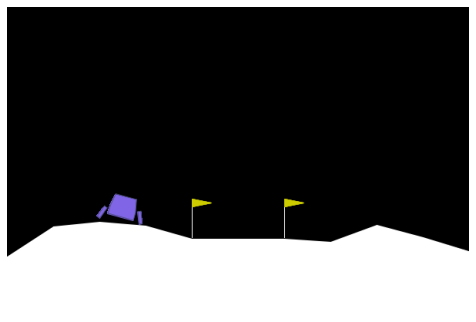

In [106]:
frames = []
fitness_function_pt(best, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
env.close()
save_frames_as_gif(frames, filename='evolved_lander_RL.gif')

MovieWriter imagemagick unavailable; using Pillow instead.


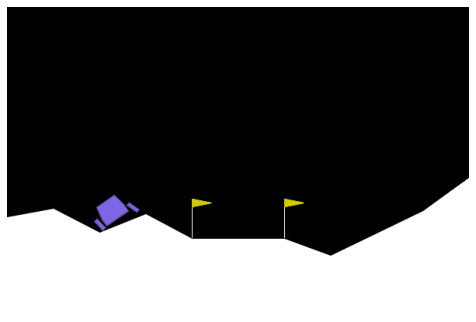

In [107]:
frames = []
fitness_with_success_shaping(best_new, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
env.close()
save_frames_as_gif(frames, filename='evolved_lander_RL_new.gif')

<img src="evolved_lander_RL.gif" width="750">